<a href="https://www.kaggle.com/code/asteriosterzis/medgemma-impact-challenge?scriptVersionId=299862902" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Med-AI Clinical Interpreter

## Hybrid Intelligence: Predictive ML + Generative Medical Reasoning

**MedGemma Impact Challenge Submission**

---

### Project Overview

This notebook demonstrates a **clinical decision support system** that combines:

1. **Random Forest (ML)**: Analyzes patient tabular data to predict cardiovascular risk
2. **MedGemma (LLM)**: Translates predictions into human-readable clinical reports

**Key Innovation**: Bridging the gap between "black-box" ML predictions and actionable medical insights.

---

### Use Cases

- **Clinician Briefing**: Technical summary for cardiologists with key risk factors
- **Patient Communication**: Warm, accessible letter explaining results to patients
- **Explainability**: Transparent AI reasoning visible in the "AI Reasoning Log"

---

**Safety Note**: This tool is for clinical decision *support* only. All outputs must be validated by licensed medical professionals.

---
## Section 1: Setup & Dependencies

In [1]:
# Install required packages
!pip install -q transformers accelerate bitsandbytes gradio
!pip install -q pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 30.8 MB/s eta 0:00:00


In [2]:
# Core imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# LLM imports
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

# UI
import gradio as gr

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


---
## Section 2: Data Loading & ML Model

We use the UCI Heart Disease dataset - a standard benchmark for cardiovascular risk prediction.

In [3]:
# Feature name mapping: technical names -> human-readable medical terms
FEATURE_MAPPING = {
    'age': 'Age (years)',
    'sex': 'Gender (1=Male, 0=Female)',
    'cp': 'Chest Pain Type (0-3)',
    'trestbps': 'Resting Blood Pressure (mm Hg)',
    'chol': 'Cholesterol Level (mg/dl)',
    'fbs': 'Fasting Blood Sugar > 120 mg/dl',
    'restecg': 'Resting ECG Results',
    'thalach': 'Maximum Heart Rate',
    'exang': 'Exercise Induced Angina',
    'oldpeak': 'ST Depression (Exercise)',
    'slope': 'ST Segment Slope',
    'ca': 'Major Vessels Blocked (0-3)',
    'thal_fixed': 'Thalassemia (Fixed Defect)',
    'thal_normal': 'Thalassemia (Normal)',
    'thal_reversible': 'Thalassemia (Reversible)'
}

def get_human_readable_name(tech_name):
    """Convert technical feature name to human-readable format."""
    return FEATURE_MAPPING.get(tech_name, tech_name)

In [4]:
    # Load and prepare data
DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
raw_df = pd.read_csv(DATA_URL)

print(f"Dataset shape: {raw_df.shape}")
print(f"\nFeatures: {list(raw_df.columns)}")
raw_df.head()

Dataset shape: (303, 14)

Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [5]:
# Preprocessing: One-hot encode categorical variables
df_processed = pd.get_dummies(raw_df)

# Split features and target
y = df_processed['target']
X = df_processed.drop('target', axis=1)
feature_names = list(X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Features after encoding: {len(feature_names)}")

Training samples: 242
Test samples: 61
Features after encoding: 17


In [6]:
# Train Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_prob)

print(f"Model Accuracy: {accuracy:.2%}")
print(f"AUC-ROC Score: {auc_score:.3f}")

Model Accuracy: 85.25%
AUC-ROC Score: 0.897


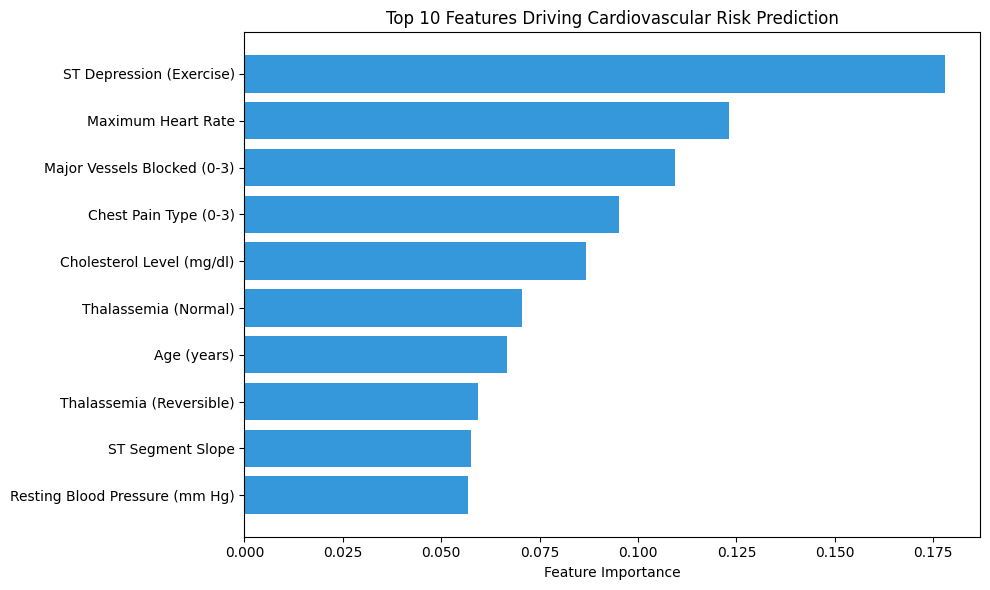

In [7]:
# Visualize Global Feature Importance
importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(
    [get_human_readable_name(feature_names[i]) for i in sorted_idx],
    importances[sorted_idx],
    color='#3498db'
)
plt.xlabel('Feature Importance')
plt.title('Top 10 Features Driving Cardiovascular Risk Prediction')
plt.tight_layout()
plt.show()

---
## Section 3: MedGemma Integration

Loading MedGemma with 4-bit quantization to fit within GPU memory constraints.

In [8]:
from huggingface_hub import login
import os

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    HF_TOKEN = user_secrets.get_secret("HF_TOKEN")
    print("Using Kaggle Secrets for authentication")
except:
    HF_TOKEN = "YOUR_HF_TOKEN_HERE"
    print("Using manual token")

# Login to Hugging Face
login(token=HF_TOKEN)
print("Hugging Face authentication successful!")

Using Kaggle Secrets for authentication
Hugging Face authentication successful!


In [9]:
# Load MedGemma 1.5 4B with quantization
MODEL_ID = "google/medgemma-1.5-4b-it"  # Correct model ID for the competition

# Quantization config for memory efficiency (fits on T4 GPU)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

print("Loading MedGemma tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(
    MODEL_ID,
    token=HF_TOKEN
)

print("Loading MedGemma model (this may take 2-3 minutes)...")
medgemma_model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    quantization_config=bnb_config,
    device_map="auto",
    token=HF_TOKEN
)

print("MedGemma 1.5 4B loaded successfully!")

Loading MedGemma tokenizer...


config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Loading MedGemma model (this may take 2-3 minutes)...


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

MedGemma 1.5 4B loaded successfully!


In [10]:
def call_medgemma(prompt, max_tokens=500, temperature=0.1):
    """
    Call MedGemma with a prompt and return cleaned response.
    """
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    outputs = medgemma_model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=temperature,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract only the model's response (after the prompt)
    if "model\n" in response:
        response = response.split("model\n")[-1].strip()
    
    return response


def clean_thinking_process(text):
    """
    Remove Chain-of-Thought reasoning from MedGemma output.
    MedGemma 1.5 uses <unused94>thought tags for internal reasoning.
    """
    import re
    
    # Remove the <unused94>thought tag and everything before actual content
    if "<unused94>" in text:
        # Try to find where the actual response starts
        # Usually after the thinking block ends
        text = re.sub(r'<unused94>thought.*?(?=Dear|Clinical|Summary|Analysis|The patient|Based on|This patient)', 
                      '', text, flags=re.DOTALL)
    
    # If still contains thinking markers, use line-by-line filtering
    if any(x in text.lower() for x in ["<unused", "thought", "**risk score:**", "**key contributing"]):
        lines = text.split('\n')
        filtered_lines = []
        skip_mode = True  # Start in skip mode
        
        for line in lines:
            # Check if we've reached actual content
            if any(marker in line for marker in ["Dear Patient", "Clinical Summary", "The machine learning", 
                                                   "The risk score indicates", "Based on the", "This patient"]):
                skip_mode = False
            
            if not skip_mode:
                filtered_lines.append(line)
        
        if filtered_lines:
            text = '\n'.join(filtered_lines).strip()
    
    # Final cleanup - find content starting markers
    markers = ["Dear Patient", "Clinical Summary", "The machine learning model", 
               "The risk score", "Based on", "This patient", "Analysis:"]
    
    for marker in markers:
        if marker in text:
            idx = text.find(marker)
            return text[idx:].strip()
    
    return text.strip()

---
## Section 4: Clinical Report Generation

The core intelligence: connecting ML predictions with medical reasoning.

In [11]:
def get_patient_analysis(patient_idx):
    """
    Analyze a patient from the test set.
    
    Returns:
        risk_score: Probability of heart disease (0-1)
        top_factors: List of top 3 contributing features
        patient_data: Dictionary of patient's clinical values
    """
    patient_row = X_test.iloc[patient_idx]
    patient_data = patient_row.to_dict()
    
    # ML Prediction - Use DataFrame to avoid sklearn warning
    patient_df = pd.DataFrame([patient_row.values], columns=feature_names)
    risk_score = rf_model.predict_proba(patient_df)[0][1]
    
    # Find top contributing features
    global_importance = rf_model.feature_importances_
    patient_values = np.abs(patient_row.values)
    local_importance = global_importance * patient_values
    
    top_indices = np.argsort(local_importance)[-3:][::-1]
    top_factors = []
    for idx in top_indices:
        name = feature_names[idx]
        value = patient_data[name]
        human_name = get_human_readable_name(name)
        top_factors.append(f"{human_name}: {value}")
    
    return risk_score, top_factors, patient_data

In [12]:
def generate_clinical_briefing(risk_score, top_factors, patient_data):
    """
    Generate a technical briefing for clinicians with medical context.
    """
    factors_str = ", ".join(top_factors)
    
    # Determine risk level
    if risk_score > 0.6:
        risk_level = "HIGH"
    elif risk_score > 0.4:
        risk_level = "MODERATE"
    else:
        risk_level = "LOW"
    
    # Add medical context for dangerous values
    warnings = []
    chol = patient_data.get('chol', 0)
    ca = patient_data.get('ca', 0)
    oldpeak = patient_data.get('oldpeak', 0)
    trestbps = patient_data.get('trestbps', 0)
    
    if chol > 240:
        warnings.append(f"CRITICAL: Cholesterol {chol} mg/dl is HIGH (normal <200)")
    if ca > 0:
        warnings.append(f"WARNING: {int(ca)} blocked vessel(s) detected")
    if oldpeak > 2.0:
        warnings.append(f"WARNING: ST Depression {oldpeak} indicates possible ischemia")
    if trestbps > 140:
        warnings.append(f"NOTE: Elevated blood pressure ({trestbps} mm Hg)")
    
    warnings_str = "\n".join(warnings) if warnings else "No critical flags detected."
    
    prompt = f"""<start_of_turn>user
You are a clinical decision support assistant for a cardiologist.

PATIENT ANALYSIS:
- ML Risk Score: {risk_score:.0%} ({risk_level} RISK)
- Key Factors: {factors_str}

CLINICAL FLAGS:
{warnings_str}

Write a 3-4 sentence technical briefing. Be ACCURATE about the risk level.
If there are warnings, emphasize them. Start with "The machine learning model"

IMPORTANT: Do not downplay warnings. If cholesterol is >240, say it's HIGH.
<end_of_turn>
<start_of_turn>model
The machine learning model"""
    
    response = call_medgemma(prompt, max_tokens=300)
    cleaned = clean_thinking_process(response)
    
    if not cleaned.startswith("The machine"):
        cleaned = "The machine learning model " + cleaned
    
    return cleaned


def generate_patient_letter(risk_score, top_factors, patient_data):
    """
    Generate a warm, accessible letter for patients.
    Reassuring but clear about follow-up needs.
    """
    factors_str = ", ".join(top_factors)
    
    # Accurate risk description
    if risk_score > 0.6:
        risk_desc = "shows some areas that need attention"
    elif risk_score > 0.4:
        risk_desc = "shows a moderate level that we should discuss"
    else:
        risk_desc = "is within a good range"
    
    # Check for concerning values - with gentler wording
    chol = patient_data.get('chol', 0)
    ca = patient_data.get('ca', 0)
    
    concerns = []
    if chol > 240:
        concerns.append("your cholesterol level is higher than we'd like to see")
    if ca > 0:
        concerns.append("we found some areas in your heart vessels that we'd like to monitor")
    
    concern_str = " However, " + " and ".join(concerns) + "." if concerns else ""
    
    prompt = f"""<start_of_turn>user
Write a warm, reassuring letter to a patient about their heart screening.

RESULTS:
- Risk assessment: {risk_desc}
- Factors reviewed: {factors_str}
- Specific concerns: {concern_str if concerns else "None noted"}

REQUIREMENTS:
1. Start with "Dear Patient,"
2. Be reassuring but honest - don't hide concerns
3. If there are concerns, explain they are manageable with proper care
4. Emphasize this is about prevention and staying healthy
5. Encourage follow-up with their doctor as a positive step
6. Maximum 5 sentences

TONE: Warm, supportive, empowering - not alarming
<end_of_turn>
<start_of_turn>model
Dear Patient,"""
    
    response = call_medgemma(prompt, max_tokens=250)
    cleaned = clean_thinking_process(response)
    
    if not cleaned.startswith("Dear"):
        cleaned = "Dear Patient,\n\n" + cleaned
    
    return cleaned

In [13]:
# Test Case 1: The Hidden Time Bomb (Patient 11)
print("="*70)
print("DEMO CASE 1: THE HIDDEN TIME BOMB")
print("="*70)
risk1, factors1, data1 = get_patient_analysis(11)
print(f"\nPatient Index: 11")
print(f"Risk Score: {risk1:.1%}")
print(f"Cholesterol: {data1.get('chol', 'N/A')} mg/dl")
print(f"Top Factors: {factors1}")
print("\n--- CLINICIAN BRIEFING ---")
print(generate_clinical_briefing(risk1, factors1, data1))
print("\n--- PATIENT LETTER ---")
print(generate_patient_letter(risk1, factors1, data1))

DEMO CASE 1: THE HIDDEN TIME BOMB

Patient Index: 11
Risk Score: 45.8%
Cholesterol: 564 mg/dl
Top Factors: ['Cholesterol Level (mg/dl): 564', 'Maximum Heart Rate: 160', 'Resting Blood Pressure (mm Hg): 115']

--- CLINICIAN BRIEFING ---
The machine learning model indicates a moderate risk for this patient, primarily driven by a significantly elevated cholesterol level of 564 mg/dl. This level is considered high, exceeding the typical threshold of 200 mg/dl, and is a major contributing factor to the calculated 46% risk score. While the maximum heart rate and resting blood pressure are within acceptable ranges, the high cholesterol warrants immediate attention and further evaluation to assess the patient's overall cardiovascular risk profile and determine appropriate management strategies.

--- PATIENT LETTER ---
Dear Patient,

I'm writing to follow up on your recent heart screening. We've reviewed your results, and while your overall health is good, your cholesterol level is a bit higher

In [14]:
# Test Case 2: False Sense of Security (Patient 31)
print("="*70)
print("DEMO CASE 2: FALSE SENSE OF SECURITY")
print("="*70)
risk2, factors2, data2 = get_patient_analysis(31)
print(f"\nPatient Index: 31")
print(f"Risk Score: {risk2:.1%}")
print(f"Blocked Vessels: {data2.get('ca', 'N/A')}")
print(f"Top Factors: {factors2}")
print("\n--- CLINICIAN BRIEFING ---")
print(generate_clinical_briefing(risk2, factors2, data2))
print("\n--- PATIENT LETTER ---")
print(generate_patient_letter(risk2, factors2, data2))

DEMO CASE 2: FALSE SENSE OF SECURITY

Patient Index: 31
Risk Score: 1.2%
Blocked Vessels: 1
Top Factors: ['Maximum Heart Rate: 158', 'Cholesterol Level (mg/dl): 201', 'Resting Blood Pressure (mm Hg): 134']

--- CLINICIAN BRIEFING ---
The machine learning model indicates a low risk of cardiovascular events for this patient, with a 1% probability. Key factors contributing to this assessment include a maximum heart rate of 158 bpm, a cholesterol level of 201 mg/dl, and a resting blood pressure of 134 mm Hg. However, a critical warning flag has been identified: the model detected one blocked vessel. This suggests a potential need for further evaluation and management, particularly concerning the coronary artery system.

--- PATIENT LETTER ---
Dear Patient,

I'm writing to share the results of your recent heart screening. We've reviewed your risk factors, including your maximum heart rate, cholesterol level, and resting blood pressure, and your overall risk assessment is within a good range

---
## Section 5: Interactive Demo (Gradio UI)

A professional interface for clinical use.

In [15]:
def analyze_patient_full(patient_idx):
    """
    Full analysis pipeline for Gradio interface.
    """
    patient_idx = int(patient_idx)
    
    # Get ML analysis
    risk_score, top_factors, patient_data = get_patient_analysis(patient_idx)
    
    # Generate reports
    clinical_report = generate_clinical_briefing(risk_score, top_factors, patient_data)
    patient_letter = generate_patient_letter(risk_score, top_factors, patient_data)
    
    # Format risk display with color indicator
    if risk_score > 0.6:
        risk_display = f"HIGH RISK: {risk_score:.1%}"
    elif risk_score > 0.4:
        risk_display = f"MODERATE RISK: {risk_score:.1%}"
    else:
        risk_display = f"LOW RISK: {risk_score:.1%}"
    
    factors_display = "\n".join([f"* {f}" for f in top_factors])
    
    # Add warnings to factors display
    warnings = []
    if patient_data.get('chol', 0) > 240:
        warnings.append(f"WARNING: High Cholesterol ({patient_data['chol']} mg/dl)")
    if patient_data.get('ca', 0) > 0:
        warnings.append(f"WARNING: Blocked Vessels ({int(patient_data['ca'])})")
    if patient_data.get('oldpeak', 0) > 2.0:
        warnings.append(f"WARNING: ST Depression ({patient_data['oldpeak']})")
    
    if warnings:
        factors_display += "\n\n--- CLINICAL FLAGS ---\n" + "\n".join(warnings)
    
    # Create feature importance plot
    fig, ax = plt.subplots(figsize=(8, 4))
    global_imp = rf_model.feature_importances_
    sorted_idx = np.argsort(global_imp)[-5:]
    ax.barh(
        [get_human_readable_name(feature_names[i]) for i in sorted_idx],
        global_imp[sorted_idx],
        color='#3498db'
    )
    ax.set_xlabel('Importance')
    ax.set_title('Key Risk Factors (Global)')
    plt.tight_layout()
    
    return risk_display, factors_display, clinical_report, patient_letter, fig


# Build Gradio Interface
with gr.Blocks(
    theme=gr.themes.Soft(),
    title="Med-AI Clinical Interpreter"
) as demo:
    
    gr.Markdown("""
    # Med-AI Clinical Interpreter
    ### Hybrid Intelligence: Random Forest + MedGemma Medical Reasoning
    
    **Demo Cases:**
    - Patient **11**: Moderate risk with critically high cholesterol (564 mg/dl)
    - Patient **31**: Low risk BUT has blocked vessel (hidden danger)
    """)
    
    with gr.Row():
        with gr.Column(scale=1):
            patient_slider = gr.Slider(
                minimum=0,
                maximum=len(X_test)-1,
                step=1,
                value=11,
                label="Select Patient Index"
            )
            analyze_btn = gr.Button(
                "Analyze Patient",
                variant="primary"
            )
            
            gr.Markdown("---")
            risk_output = gr.Textbox(label="Risk Assessment", lines=1)
            factors_output = gr.Textbox(
                label="Key Factors & Warnings",
                lines=8
            )
            plot_output = gr.Plot(label="Feature Importance")
        
        with gr.Column(scale=2):
            with gr.Tabs():
                with gr.TabItem("Clinician Briefing"):
                    clinical_output = gr.Textbox(
                        label="Technical Summary",
                        lines=10
                    )
                    gr.Markdown(
                        "*Decision support tool - not a diagnostic device.*"
                    )
                
                with gr.TabItem("Patient Letter"):
                    patient_output = gr.Textbox(
                        label="Patient Communication",
                        lines=10
                    )
                    gr.Markdown(
                        "*Draft only - review before sharing with patient.*"
                    )
    
    gr.Markdown("""
    ---
    **Safety Disclaimer**: This tool uses MedGemma for medical text synthesis. 
    All outputs require validation by licensed healthcare professionals.
    """)
    
    analyze_btn.click(
        fn=analyze_patient_full,
        inputs=[patient_slider],
        outputs=[risk_output, factors_output, clinical_output, patient_output, plot_output]
    )

demo.launch(share=True)

/tmp/ipykernel_23/928332719.py:53: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://84eb849de445b3b3f2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
## Conclusion

### What We Built

A **Hybrid Clinical Decision Support System** that:

1. **Predicts** cardiovascular risk using interpretable ML (Random Forest)
2. **Explains** predictions in clinical context using MedGemma
3. **Communicates** results appropriately for different audiences

### Key Innovations

- **Clinician-Centric Alerts**: The system highlights critical anomalies (e.g., blocked vessels, extreme cholesterol) even when aggregate risk scores are low
- **Automated Translation**: Translates complex hemodynamic data into empathetic patient communication
- **Auditability**: Full transparency via clinical flags, mitigating the "black box" nature of traditional ML
- **Context-Aware Reporting**: MedGemma receives structured clinical context and emphasizes concerns appropriately
- **Safety First**: Clear disclaimers, human-in-the-loop design

### Demo Highlights

- **Patient 11 ("The Hidden Time Bomb")**: Shows how the system catches critically high cholesterol (564 mg/dl) even in a "moderate risk" patient
- **Patient 31 ("False Sense of Security")**: Demonstrates how the system flags a blocked vessel despite a low (1.2%) risk score - preventing dangerous complacency

### Future Directions

- Integration with EHR systems (FHIR API)
- Support for medical imaging (X-rays, CT scans) via MedGemma multimodal
- Multi-language patient communication
- PDF export for clinical documentation
- Real-time monitoring dashboards